In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
# I was getting a ModuleNotFoundError, and I discovered that the cwd (current working directory) was
#   '<Github Home>/market-modeling/examples/' but it needs to be '<Github Home>/market-modeling/'
# The following code will add the cwd's parent directory to the path Python uses to search for packages
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
from datetime import datetime, timedelta

from models.geom_growth_models.Models import IndependentModel

import pandas as pd

from examples import create_market, plot_predictions

In [4]:
DEBUG = False
market = create_market('../data', 'popular_stocks', 'growth_timeseries', DEBUG)

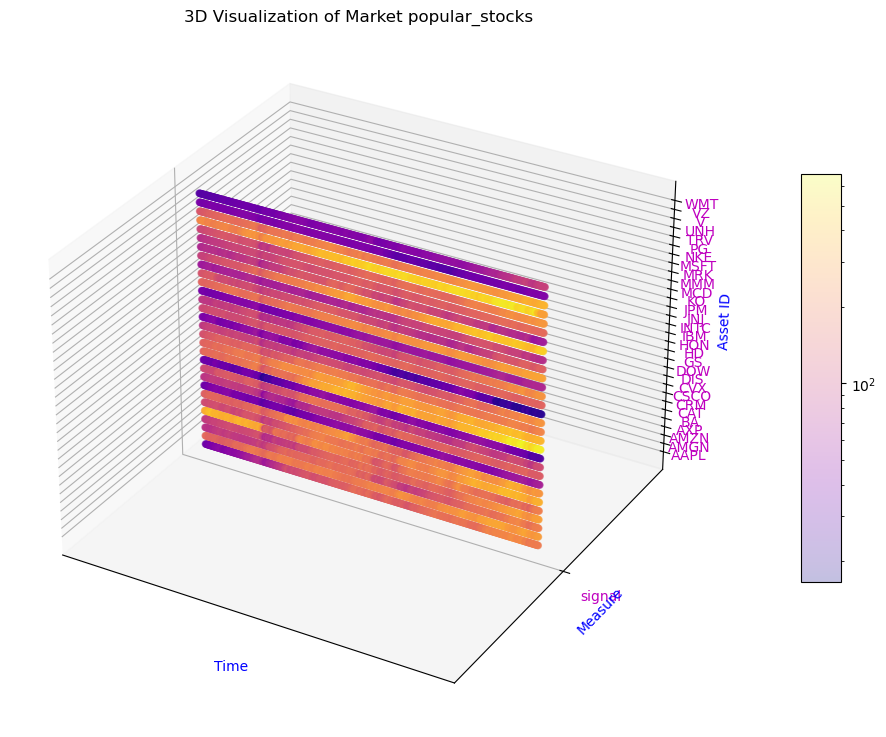

In [5]:
market.align_timeseries(True)
market.display_market(show_indicators=False)

In [6]:
train_split, val_split, test_split = market.train_test_split(0.2, 0.1)

## Fit Dependent Model to the Most Recent Data

In [7]:
indep_model = IndependentModel()

(mkt_drifts, mkt_vols), train_hist = indep_model.fit_local_params(None, test_split)

In [8]:
train_hist['train_loss'], train_hist['train_MAE']

([393588.375], [0.059147632231961775])

In [9]:
summ_df = pd.DataFrame({
	'ticker': market.xarray_ds['ID'].values,
	'mean': mkt_drifts,
	'sigma': mkt_vols
})

summ_df

,ticker,mean,sigma
0,AAPL,-0.000225,0.000441
1,AMGN,-0.000277,0.000271
2,AMZN,0.000749,0.000463
3,AXP,0.000628,0.000444
4,BA,0.001706,0.000609
5,CAT,-0.000308,0.000366
6,CRM,0.000027,0.000437
7,CSCO,0.000986,0.000204
8,CVX,-0.000047,0.000273
9,DIS,0.001036,0.000433


## Forecast Near-Future

In [10]:
LAST_DATE = datetime.fromtimestamp(int(market.xarray_ds['time'].max().to_numpy())//1e9)
dates_to_sim = pd.to_datetime(
  pd.Series([
	  LAST_DATE+timedelta(days=2),
	  LAST_DATE+timedelta(days=5),
	  LAST_DATE+timedelta(days=20),
	  LAST_DATE+timedelta(days=30),
  ], name='dates'),
  format='%m-%d-%Y'
)

prev_time, prev_state = market.get_market_state_before_date(min(dates_to_sim))
prev_signals = prev_state.sel(variable='signal').to_numpy()

sim_dates = pd.concat((pd.Series(prev_time, name='dates'), dates_to_sim))

In [11]:
sim_res = indep_model.simulate(
	None, prev_signals, sim_dates, num_sims=20,
	mu=mkt_drifts, vols=mkt_vols
)

sim_counterfact = indep_model.simulate(
	None, prev_signals, sim_dates, 1, add_BM=False,
	mu=mkt_drifts, vols=mkt_vols
)

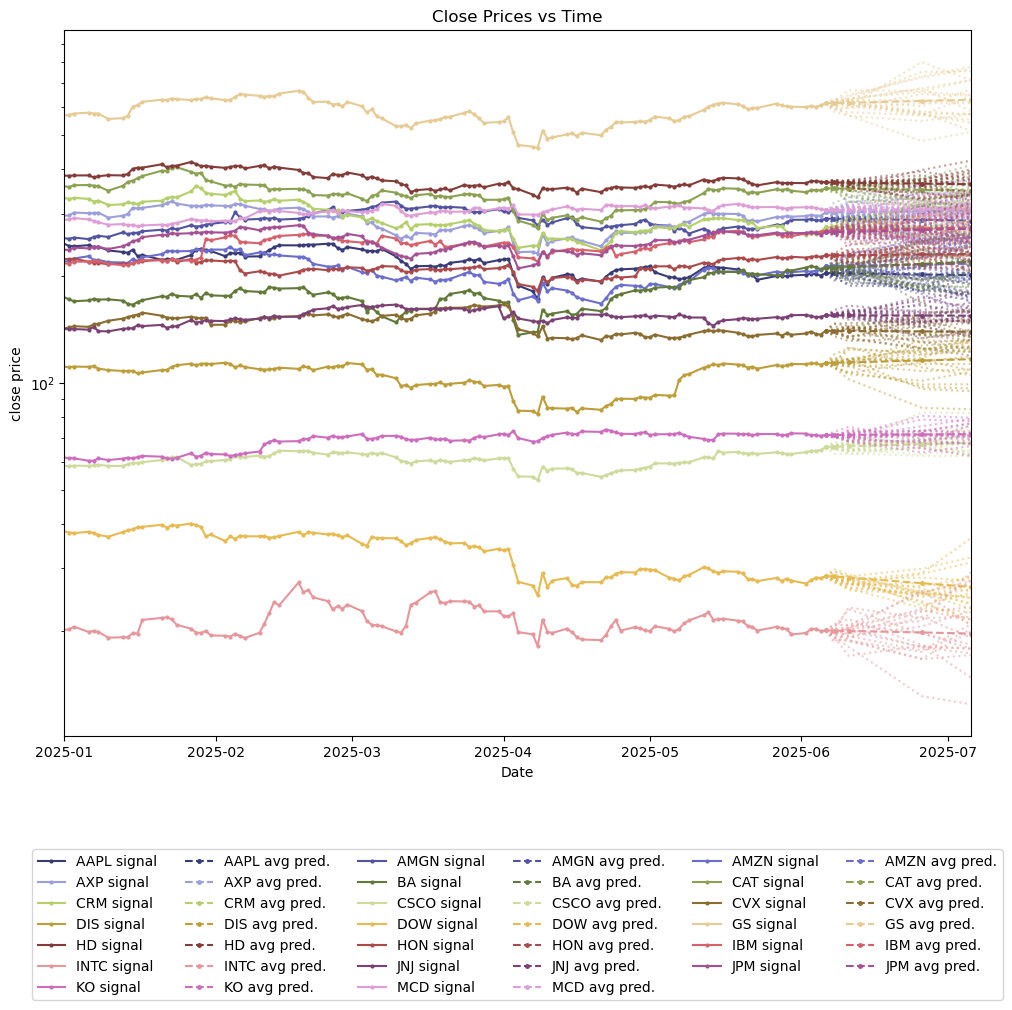

In [12]:
plot_predictions(market, sim_dates, sim_res, sim_counterfact)